In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import tables
# pip install simweights <--- run this once to install the package
# then replace <username> with your username and <version> with your Python version
sys.path.append('/home/ahinners/.local/lib/python3.11/site-packages')
import simweights

In [2]:
# Load in half the SIBYLL2.1 particle sims (The kernel might crash otherwise)
proton_filelist = glob.glob("/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/p/12360_v1s/h5files/*.h5")
helium_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/He/12630_v1s/h5files/*.h5')

bigfilelist = proton_filelist + helium_filelist

In [3]:
# Load in the other hlaf of SIBYLL2.1 particle sims
oxygen_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/O/12631_v1s/h5files/*.h5')
iron_filelist = glob.glob("/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/Fe/12362_v1s/h5files/*.h5")

bigfilelist += oxygen_filelist + iron_filelist

In [4]:
# Set the weighter for the data
weighter = None
for filename in bigfilelist:
    file_obj = tables.open_file(filename, "r")
    if weighter is None:
        weighter = simweights.IceTopWeighter(file_obj)
    else:
        weighter += simweights.IceTopWeighter(file_obj)

In [5]:
primary_energy = weighter.get_column("MCPrimary", "energy")
# (p, He, N, Al, Fe) version of this model.
fluxH = simweights.GaisserH4a_IT()

# Get the weights by passing the flux to the weighter
weights = weighter.get_weights(fluxH)

type = weighter.get_column('MCPrimary', 'type')

In [6]:
# Dictionary for weight data (practice in using dictionaries)
CUTS = {
    'proton': weighter.get_column("MCPrimary", "type")==2.21200000e+03,
    'helium' : weighter.get_column("MCPrimary", "type")==1.00002004e+09,
    'oxygen': weighter.get_column("MCPrimary", "type")==1.00008016e+09,
    'iron': weighter.get_column("MCPrimary", "type")==1.00026056e+09,
    'true': np.tile(True, len(primary_energy))
}
#FRAC = {
#   'true': 1,
#    'proton': np.log10(primary_energy[CUTS['proton']]) / primary_energy,
#    'helium': np.log10(primary_energy[CUTS['helium']]) / primary_energy,
#    'oxygen': np.log10(primary_energy[CUTS['oxygen']]) / primary_energy,
#    'iron': np.log10(primary_energy[CUTS['iron']]) /primary_energy
# [counts==livetime]
Z = {
    'true': 0,
    'proton': 1,
    'helium': 2,
    'oxygen': 8,
    'iron': 26  
}
COLORS={
    'true' : 'black',
    'proton': 'red',
    'helium': 'orange',
    'oxygen': 'green',
    'iron': 'blue'
}
LABEL={
    'true' : 'Data',
    'proton': 'P',
    'helium': 'He',
    'oxygen': 'O',
    'iron': 'Fe'
}
WEIGHTS={}

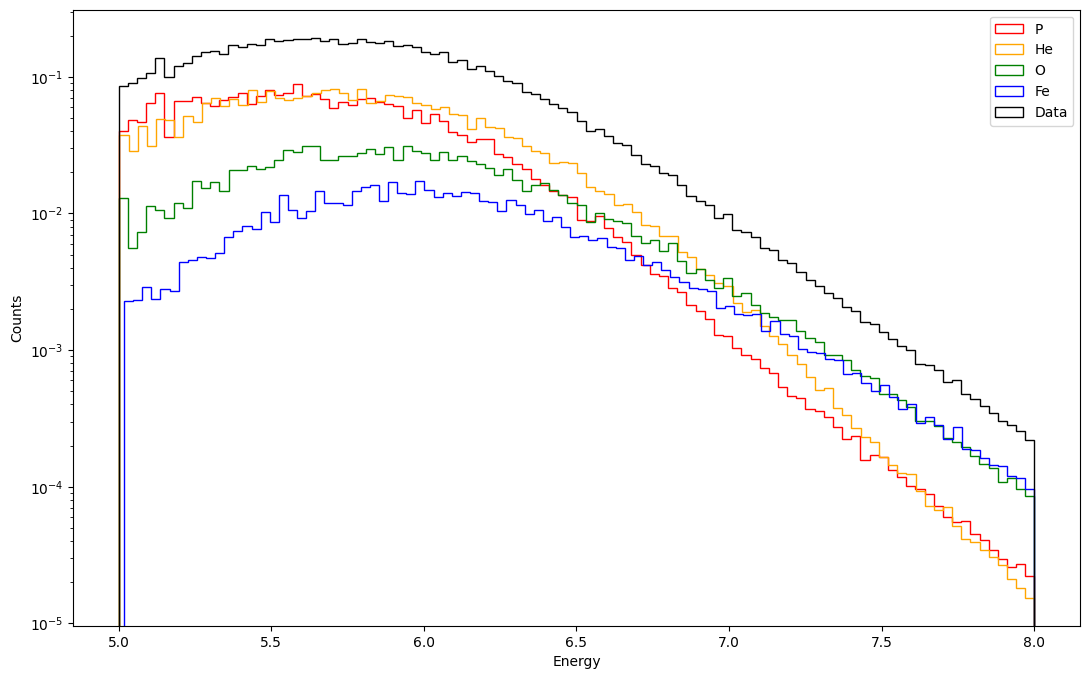

In [7]:
# Graph Log10 Energy vs Log 10 weighted counts

# Practice with dictionary
fig, axs = plt.subplots(figsize = (13, 8))
for cut in CUTS:
    WEIGHTS[cut], bins, patches1 = axs.hist(np.log10(primary_energy)[CUTS[cut]], bins=100, weights=weights[CUTS[cut]], log=True, label = LABEL[cut], histtype='step', color=COLORS[cut])
    axs.set_xlabel('Energy')
    axs.set_ylabel('Counts')
plt.legend()

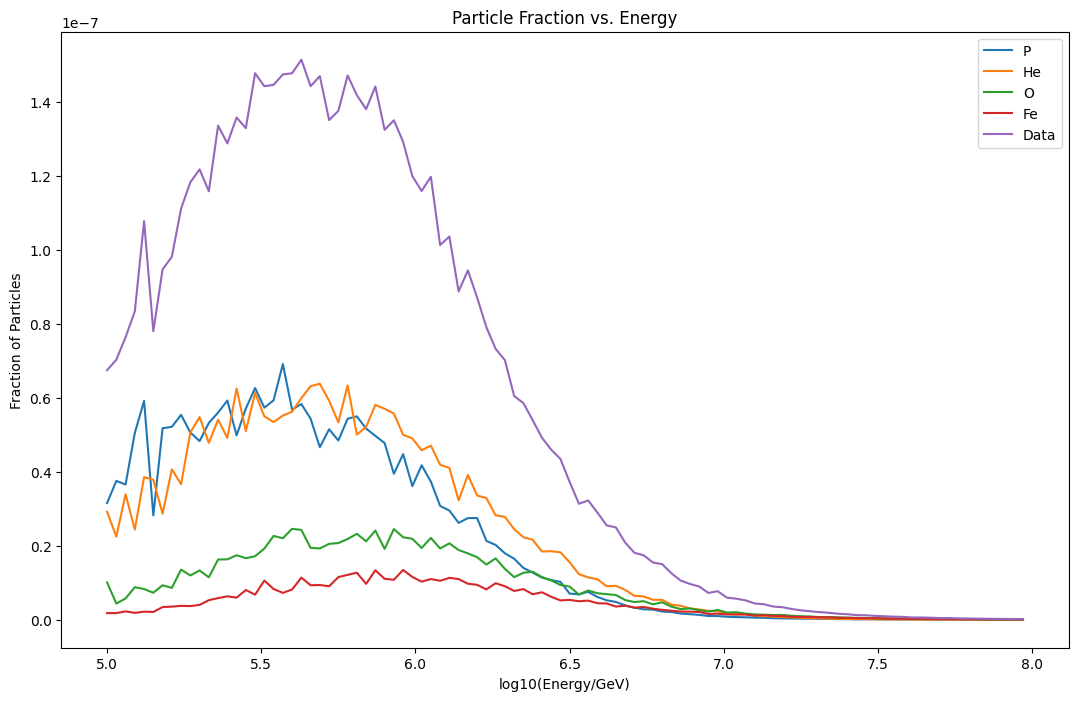

In [8]:
# attempts with dictionary
fig, axs = plt.subplots(figsize=(13, 8))
for cut in CUTS:
    axs.plot(bins[:-1], WEIGHTS[cut]/len(primary_energy), label=LABEL[cut])

plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Fraction of Particles')
plt.title('Particle Fraction vs. Energy')

plt.legend()

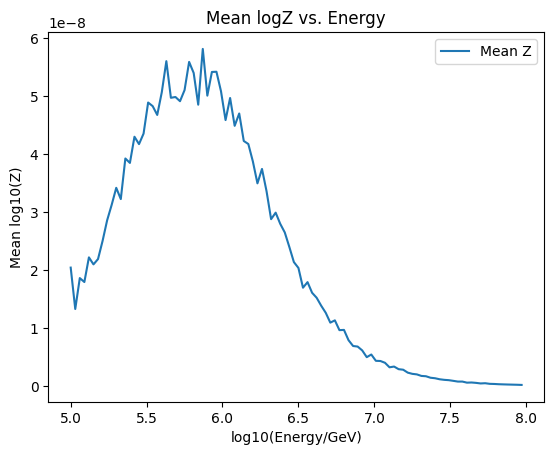

In [9]:
# Mean Atomic Charge (without dictionary)

PZ = WEIGHTS['proton'] * np.log10(1)
HeZ = WEIGHTS['helium'] * np.log10(2)
OZ = WEIGHTS['oxygen'] * np.log10(8)
FeZ = WEIGHTS['iron'] * np.log10(26)

totZ = PZ + HeZ + OZ + FeZ
meanZ = totZ / len(primary_energy)

plt.plot(bins[:-1], meanZ, label = 'Mean Z')

plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Mean log10(Z)')
plt.title('Mean logZ vs. Energy')

plt.legend()

In [10]:
# Make a table of the overall percentage of particles

# attempt with dictionary
for cut in CUTS:
    if not cut=='true':
        print(f"[{cut}, {round(len(primary_energy[CUTS[cut]])/len(primary_energy), 3)}]")

[proton, 0.263]
[helium, 0.256]
[oxygen, 0.246]
[iron, 0.235]


In [11]:
fluxG = simweights.GlobalSplineFit_IT()

print(fluxG.pdgids)
print(fluxG.groups)

(<PDGCode.PPlus: 2212>, <PDGCode.He4Nucleus: 1000020040>, <PDGCode.O16Nucleus: 1000080160>, <PDGCode.Fe56Nucleus: 1000260560>)
((1, 1), (2, 2), (3, 10), (11, 28))
